/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



No of keywords in variable 'keywords': 11462
No of keywords in variable 'keywords': 10817


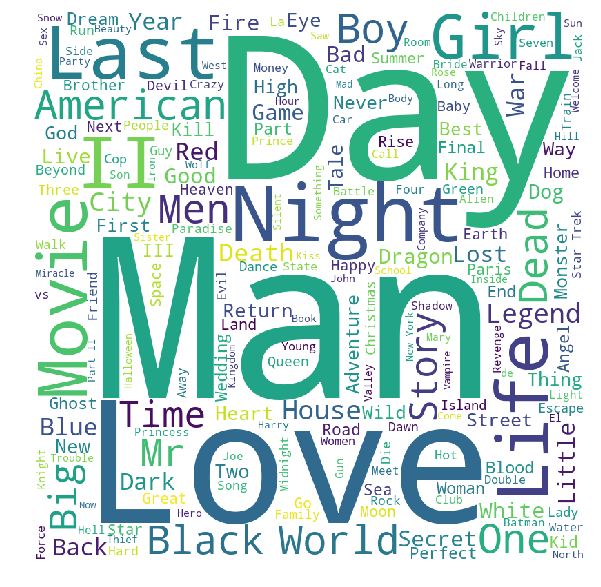

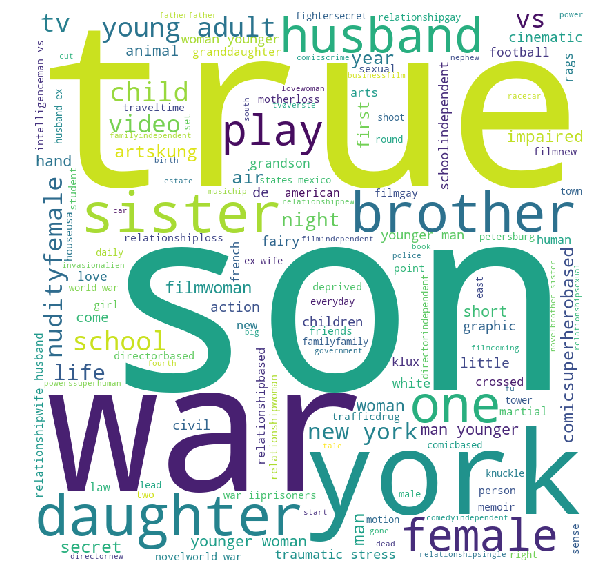

In [19]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import plotly.offline as off
import nltk
from nltk.corpus import wordnet

PS = nltk.stem.PorterStemmer()
# nltk.download()
off.init_notebook_mode(connected=True)
keywords = pd.read_csv('keywords.csv')
meta = pd.read_csv('movies_metadata.csv')
ratings = pd.read_csv('ratings_small.csv')
# credit = pd.read_csv('credits.csv')

ratings = ratings.rename(columns={'movieId':'id'})
#Convert IDs to numeric from string
meta = meta[meta.status=="Released"]
meta = meta[meta.revenue!=0]
meta = meta[meta.budget!=0]
meta.id = pd.to_numeric(meta.id,errors="coerce")
meta = meta.dropna(subset=["id"])
meta.release_date=pd.to_datetime(meta.release_date, format = '%Y-%m-%d', errors="coerce")
meta = meta.dropna(subset=["release_date"])
meta = meta.drop_duplicates(subset=['id'])
meta = meta.drop(['homepage','poster_path','production_countries','video','spoken_languages','original_title'], axis =1)
keywords = keywords[keywords.keywords!="[]"]
keywords = keywords.drop_duplicates(subset=['id'])
meta = pd.merge(meta,keywords,on='id',how='left')

tab_info=pd.DataFrame(meta.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(meta.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(meta.isnull().sum()/meta.shape[0]*100).T.rename(index={0:'null values (%)'}))


meta.popularity = pd.to_numeric(meta.popularity, errors='coerce')
tasks = ['genres','production_companies','keywords']

def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col]:        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

def convert(task):
    temp_dict = dict()
    temp_arr = []
    temp_series = meta[task]
    for item in temp_series:
        if type(item) != type(str()):
            continue
        t = literal_eval(item)
        if type(t)!=type([]):
            continue
        temp =[]
        for i in t:
            temp.append(i['name'])
            if str(i['name']) not in temp_dict.keys():
                temp_dict[str(i['name'])] = 1
            else:
                temp_dict[str(i['name'])]+=1
        temp_arr.append(temp)
    meta[task]=pd.Series(temp_arr)
    return temp_dict

genre_dict = convert(tasks[0])
prodcomp_dict = convert(tasks[1])
convert(tasks[2])

df_2 = meta
def keywords_inventory(dataframe, column = 'keywords'):
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    icount = 0
    for s in dataframe[column]:
        if type(s) == type(0.0) : continue
        for t in s:
            t = t.lower() 
            root = PS.stem(t)
            if root in keywords_roots:                
                keywords_roots[root].add(t)
            else:
                keywords_roots[root] = {t}
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    key = k ; min_length = len(k)            
            category_keys.append(key)
            keywords_select[s] = key
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("No of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

keywords_dat, keywords_roots, keywords_select = keywords_inventory(df_2 ,column = 'keywords')

def replacement_df_keywords(df, dict_repl, roots = False):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chain = row['keywords']
        if type(chain) == type(0.0) : continue
        temp = []
        for s in chain: 
            key = PS.stem(s) if roots else s
            if key in dict_repl.keys():
                temp.append(dict_repl[key])
            else:
                temp.append(s)       
        df_new.set_value(index, 'keywords', temp)
    return df_new

df_keywords_cleaned = replacement_df_keywords(df_2, keywords_select,roots = True)

keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'keywords',keywords_dat)


def get_synonyms(word_key):
    lemma = set()
    for ss in wordnet.synsets(word_key):
        for w in ss.lemma_names():
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma   

def test_keyword(word, key_count, threshold):
    return (False , True)[key_count.get(word, 0) >= threshold]

keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]

repl_word = dict()
icount = 0
for index, [word, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  
    lemma = get_synonyms(word)
    if len(lemma) == 0: continue  
    word_list = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[word])]
    word_list.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(word_list) <= 1: continue     
    if word == word_list[0][0]: continue
    repl_word[word] = word_list[0][0]

for key, value in repl_word.items():
    if value in repl_word.keys():
        repl_word[key] = repl_word[value]    
        
df_keywords_synonyms = replacement_df_keywords(df_keywords_cleaned, repl_word, roots = False)   

keywords_dat, keywords_roots, keywords_select = keywords_inventory(df_keywords_synonyms, column = 'keywords')

new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'keywords',keywords_dat)

movies_list = []
def genre_transform():
    temp_dict = dict()
    for index,row in meta.iterrows():
        movies_list.append(tuple([row.release_date.year,row.revenue]))
        for i in row.genres:
            if str(i) not in temp_dict.keys():
                temp_dict[str(i)] = [tuple([row.release_date.year,row.revenue])]
            else:
                temp_dict[str(i)].append(tuple([row.release_date.year,row.revenue]))
    return temp_dict
genre_plot_dict = genre_transform()

for key,value in genre_plot_dict.items():
    x,y = zip(*sorted(value))
    data = [dict(
      type = 'scatter',
      x = x,
      y = y,
      transforms = [dict(
        type = 'aggregate',
        groups = x,
        aggregations = [dict(
            target = 'y', func = 'sum', enabled = True),
        ]
      )]
    )]
    layout = dict(
        title='Genre: '+key,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible = True
            ),
            type='date',
            title = 'Year'
        ),
        yaxis = dict(title='revenue')
            
    )
    #change to iplot in jupyter notebook
    off.iplot({
        "data": data,
        "layout": layout
    }, validate= False)
    
x,y = zip(*sorted(movies_list))
data = [dict(
      type = 'scatter',
      x = x,
      y = y,
      transforms = [dict(
        type = 'aggregate',
        groups = x,
        aggregations = [dict(
            target = 'y', func = 'count', enabled = True),
        ]
      )]
    )]
layout = dict(
    title='Number of movies released across the years',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date',
        title = 'Year'
    ),
    yaxis = dict(title='number of movies')
        
)
#change to iplot in jupyter notebook
off.iplot({
    "data": data,
    "layout": layout
# },auto_open=True, validate= False)
},validate= False)


def convert_key():
    temp = ""
    temp_series = df_keywords_synonyms['keywords']
    for item in temp_series:
        if type(item)!=type([]):
            continue
        for i in item:
            temp = temp + i
    return temp
pd.set_option('display.max_colwidth', 50)


# Creating word cloud for title:
meta['title'] = meta['title'].astype(str)
title = ' '.join(meta['title'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(title)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

# Creating word cloud for keywords:
string = convert_key()

wordcloud_key = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(string)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_key) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()


In [13]:
from  nltk.corpus import wordnet